### Библиотеки

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
from Experiment_Burgers_1 import *

In [3]:
import sys
sys.path.append(fr'/home/mex0/Documents/TukhbatullinAL/diplom_2/Git_stencil-net/Git_stencil-net/')

from utils import burgers_simulation,burgers_upwind

In [4]:
BC_TYPE='dirichlet'; BC_VALUES=[0,0]

### Описание эксперимента:

### 0. Параметры для генерации данных

In [5]:
folder='Experiment_burgers_1'

In [6]:
# для сил
np.random.seed(0)

L = 2.0*np.pi; T_ = 40;  Al = -0.1; Ar = 0.1; wl = -0.4; wr = 0.4; N = 20
A = np.zeros((N,)); w = np.zeros((N,)); phi = np.zeros((N,)); l = np.zeros((N,))

for k in range(0, N):
    A[k] = (Ar-Al)*np.random.rand(1) + Al
    w[k] = (wr-wl)*np.random.rand(1) + wl
    phi[k] = (2.0*np.pi)*np.random.rand(1)
    l[k] = np.random.randint(2, 5)

In [7]:
# epochs_lst=[1,100,1_000,5_000,10_000]
# epochs_lst=[30_000]
epochs_lst=[1_000]

### 1. Генерация данных

In [8]:
n = 256; Tsim = 80001;
# Lx = 101; Tsim = 10001;
# n = 64; Tsim = 2001;
x_lst = np.linspace(0,L,n); h = x_lst[1] - x_lst[0]; D = 0.02; tau = 0.002

CFL = (h*h)/(2.0*D)
print("CFL dt", CFL, "actual dt", tau)

CFL dt 0.015178169013593782 actual dt 0.002


In [9]:
# ##generate (by WENO + RK3)
# v_fact, phase = burgers_simulation(Tsim, n, x_lst, D, tau, A, w, phi, l, N, L,bc_type=BC_TYPE,bc_values=BC_VALUES)

# ##save
# pickle.dump(v_fact, open(fr'{folder}/data/v_fact_n={n}_Tsim={Tsim}.pkl', 'wb'))
# pickle.dump(phase, open(fr'{folder}/data/phase_n={n}_Tsim={Tsim}.pkl', 'wb'))

##load
v_fact=pickle.load( open(fr'{folder}/data/v_fact_n={n}_Tsim={Tsim}.pkl', 'rb'))
phase=pickle.load( open(fr'{folder}/data/phase_n={n}_Tsim={Tsim}.pkl', 'rb'))

In [10]:
device

'cuda'

In [ ]:
# ##generate (by UPWIND)
# v_fact = burgers_upwind(Tsim, n, x_lst, D, tau, A, w, phi, l, N, L,bc_type=BC_TYPE,bc_values=BC_VALUES)

#save
# pickle.dump(v_fact, open(fr'{folder}/data/v_fact_UPWIND_n={n}_Tsim={Tsim}.pkl', 'wb'))

##load
# v_fact=pickle.load( open(fr'{folder}/data/v_fact_UPWIND_n={n}_Tsim={Tsim}.pkl', 'rb'))

Text(0.5, 1.0, 'Фактические данные')

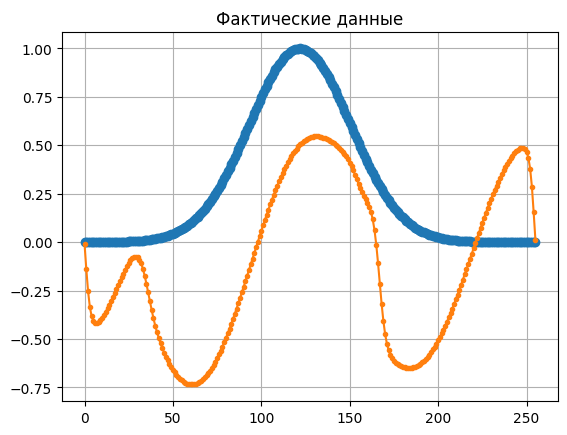

In [11]:
#view
plt.plot(v_fact[:,0],'o-')
plt.plot(v_fact[:,-1],'.-')
plt.grid()
plt.title('Фактические данные')

In [12]:
print('h',h,h**2)
print('tau',tau)
assert tau/h<=1,'не выполнено ограничение на число Куранта'

h 0.024639942381096416 0.0006071267605437513
tau 0.002


### 2. Сабсемплинг

In [13]:
# t_factor = 1  # time subsample factor 
# s_factor = 1  # space subsample factor

# t_factor = 20
# s_factor = 4

t_factor = 20
s_factor = 5

Tsim=len(v_fact[0])
dxc,dtc,coarse_t,coarse_x,v_coarse,Lxc,\
Ltc,v_coarse_train,v_coarse_test=subsampling(s_factor,t_factor,h,tau,Tsim,n,v_fact,train_split=train_split)

full_sample (52, 4001)
train (52, 1000)
test (52, 3001)


In [14]:
v_coarse_train.shape

(52, 1000)

In [15]:
# v_coarse_train[-1,:]=BC_VALUES[1]
# v_coarse_test[-1,:]=BC_VALUES[1]

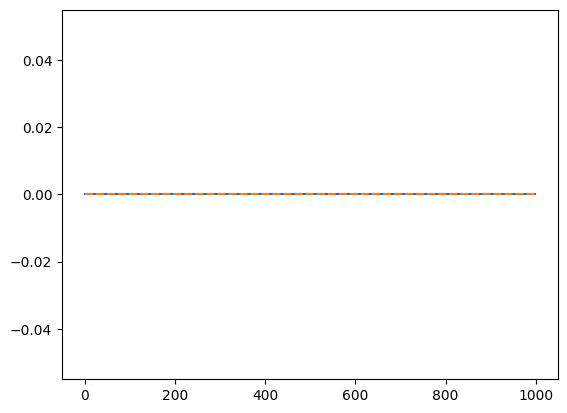

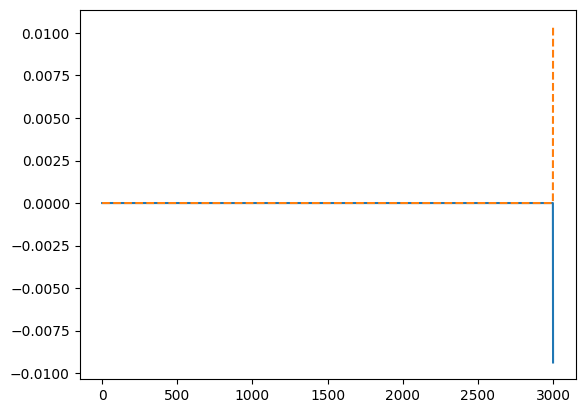

In [16]:
##check right point
plt.figure()
plt.plot(v_coarse_train[0,:])
plt.plot(v_coarse_train[-1,:],'--')

plt.figure()
plt.plot(v_coarse_test[0,:])
plt.plot(v_coarse_test[-1,:],'--')

In [17]:
dxc==dtc, dxc

(np.False_, np.float64(0.12319971190548208))

Text(0.5, 1.0, 'Фактические данные после сабсемплинга')

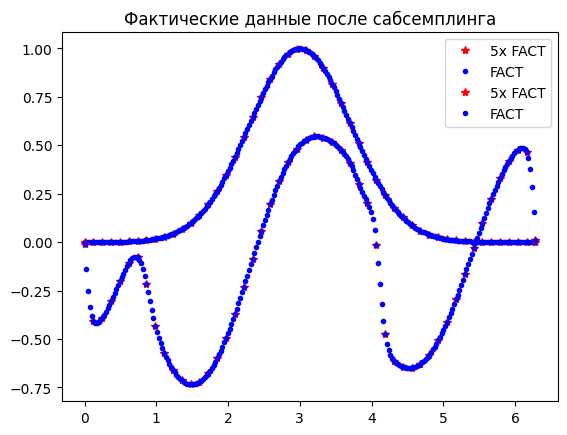

In [18]:
plt.figure()
time=0 #first time
plt.plot(x_lst[coarse_x],v_coarse[:,time],'*',color='red',label=str(s_factor) + 'x FACT')
plt.plot(x_lst,v_fact[:,t_factor*time],'.',color='blue',label='FACT')
time=v_coarse.shape[1]-1 #last time
plt.plot(x_lst[coarse_x],v_coarse[:,time],'*',color='red',label=str(s_factor) + 'x FACT')
plt.plot(x_lst,v_fact[:,t_factor*time],'.',color='blue',label='FACT')
plt.legend()
# plt.title(" Time slice at t=0 and t = " + str(time))
# plt.show()
plt.title('Фактические данные после сабсемплинга')

In [19]:
v_coarse_train.shape

(52, 1000)

In [20]:
v_coarse.shape

(52, 4001)

### 3. Тренировка модели

In [21]:
from utils import forcing_terms

Fc, Fc_0p5, Fc_p1, Fc_0m5, Fc_m1 = forcing_terms(A, w, phi, l, L, Lxc, T_, Ltc, N, dtc)

# u_train = torch.tensor(v_coarse_train.T, requires_grad=True, dtype=torch.float, device=device)
fc      = torch.tensor(Fc.T, requires_grad=True, dtype=torch.float, device=device)
fc_0p5  = torch.tensor(Fc_0p5.T, requires_grad=True, dtype=torch.float, device=device)
fc_p1   = torch.tensor(Fc_p1.T, requires_grad=True, dtype=torch.float, device=device)
fc_0m5  = torch.tensor(Fc_0m5.T, requires_grad=True, dtype=torch.float, device=device)
fc_m1   = torch.tensor(Fc_m1.T, requires_grad=True, dtype=torch.float, device=device)

In [22]:
for epochs in epochs_lst:
    
    net, loss_lst,loss=train_net(MLPConv,v_coarse_train,epochs,dtc,
              fs,
              neurons,
              hidden_layers_num,
              lr,
              m,
              has_backward,
              method,
              decay_const,
              force_terms=[fc,fc_0p5,fc_p1,fc_0m5,fc_m1],
              bc_type=BC_TYPE,bc_values=BC_VALUES)
    
    pickle.dump(net, open(fr'{folder}/models/net_epochs={epochs}_device={device}', 'wb'))
    

input 7 output 32
input 32 output 32
input 32 output 32
input 32 output 1
#parameters: 2401


100%|█████████████████████████| 1000/1000 [00:39<00:00, 25.21it/s, loss=0.00209]


In [23]:
BC_TYPE,BC_VALUES

('dirichlet', [0, 0])

In [24]:
method

'RK3'

### 4. Симуляция прогноза моделью

In [25]:
# model_name='model_forced_burgers_7_3L_32_ep_10000_elu_m4_Lxc2_Ltc10_lwd1e-07_WDactRK3_seed_4.pth'

##good model
model_name='model_forced_burgers_7_3L_32_ep_30000_elu_m4_Lxc4_Ltc20_lwd1e-07_WDactRK3_seed_1.pth'

# model_name='model_forced_burgers_7_3L_32_ep_30000_elu_m4_Lxc8_Ltc20_lwd1e-07_WDactRK3_seed_4.pth'

# model_name='model_forced_burgers_7_3L_64_ep_10000_elu_m4_Lxc2_Ltc10_lwd1e-07_WDactRK3_seed_14.pth'

# model_name='model_forced_burgers_7_3L_64_ep_10000_elu_m4_Lxc8_Ltc20_lwd1e-07_WDactRK3_seed_2.pth'

##good model
# model_name='model_forced_burgers_7_3L_64_ep_30000_elu_m4_Lxc4_Ltc20_lwd1e-07_WDactRK3_seed_1.pth'

# net=torch.load(fr'{folder}/models_authors/{model_name}',weights_only=False,map_location=device)


In [26]:
NN_sim_lst=[]

weights=[]
biases=[]

for epochs in epochs_lst:
    
    net = pickle.load(open(fr'{folder}/models/net_epochs={epochs}_device={device}', 'rb'))
    # NN_sim,T_sim,x_sim=make_simulation(net,v_coarse,L,Lxc,dtc,method=method,
                                            #   bc_type=BC_TYPE,bc_values=BC_VALUES)
    NN_sim,T_sim,x_sim=make_simulation_forcing(net,v_coarse,L,Lxc,dtc,\
                                              A,phi,N,w,l,method=method,
                                              bc_type=BC_TYPE,bc_values=BC_VALUES)
    
    NN_sim_lst.append(NN_sim)ы

    try:
        weights.append(net.layer[0].weight.data.numpy())
    except:
        weights.append(net.layer[0].weight.cpu().data.numpy())
    biases.append(None)

RK3


100%|██████████████████████████████████████| 4000/4000 [00:07<00:00, 501.86it/s]


In [27]:
net.parameters

<bound method Module.parameters of MLPConv(
  (sig): ELU(alpha=1.0)
  (layer): ModuleList(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1-2): 2 x Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)>

In [28]:
pd.DataFrame({'epoch':epochs_lst,#+[['finite_diff_methods']],
              'coefs':weights,#+[[1/((dxc)),-1/(dxc),0]],
              'bias':biases})#+[[None]]})

,epoch,coefs,bias
0,1000,"[[-0.14837734, 0.2214175, 0.022025364, 0.34646...",None


In [29]:
print(dxc)

0.12319971190548208


### 5. Результаты

In [30]:
T=round(T_sim*dtc,3)
T

160.04

In [31]:
err=np.abs(v_coarse-NN_sim)
mae_list=[err[:,i].mean() for i in range(err.shape[1])]
mae_df=pd.DataFrame({'method':method,'mae_list':mae_list}).to_csv(fr'{method}_mae.csv')

In [32]:
method

'RK3'

---------------Epochs = 1000-------------------


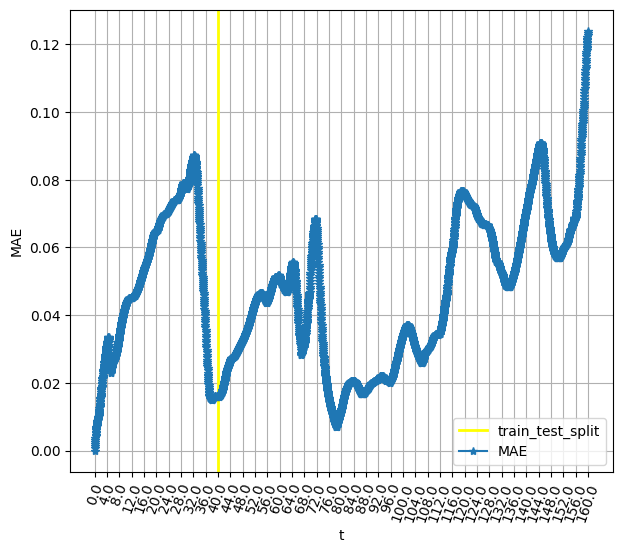

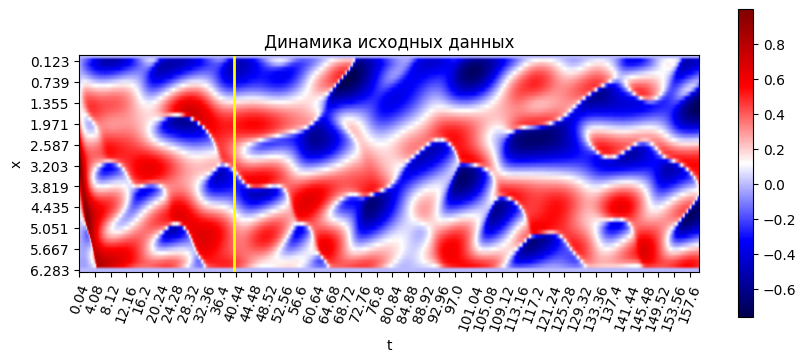

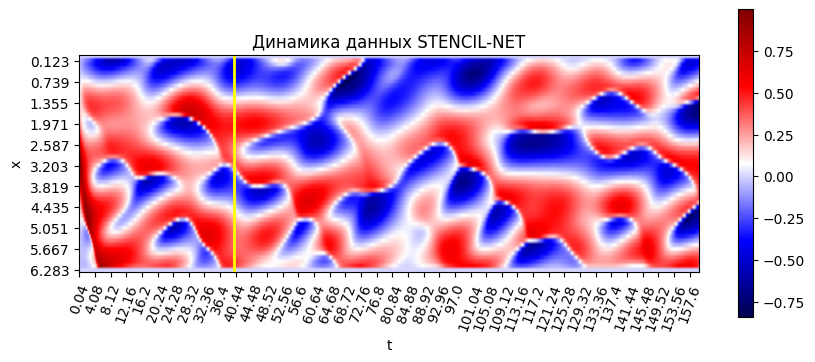

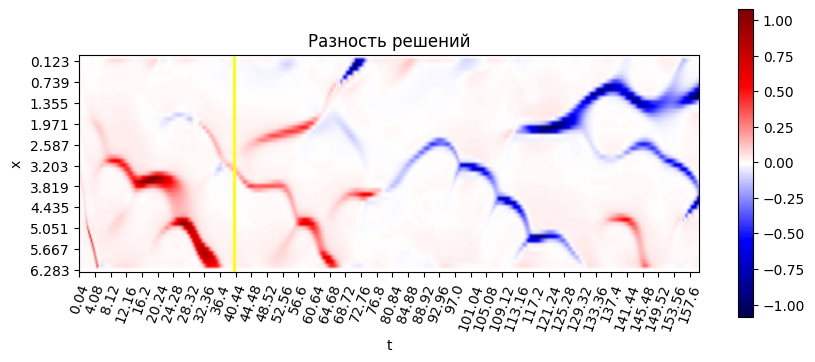

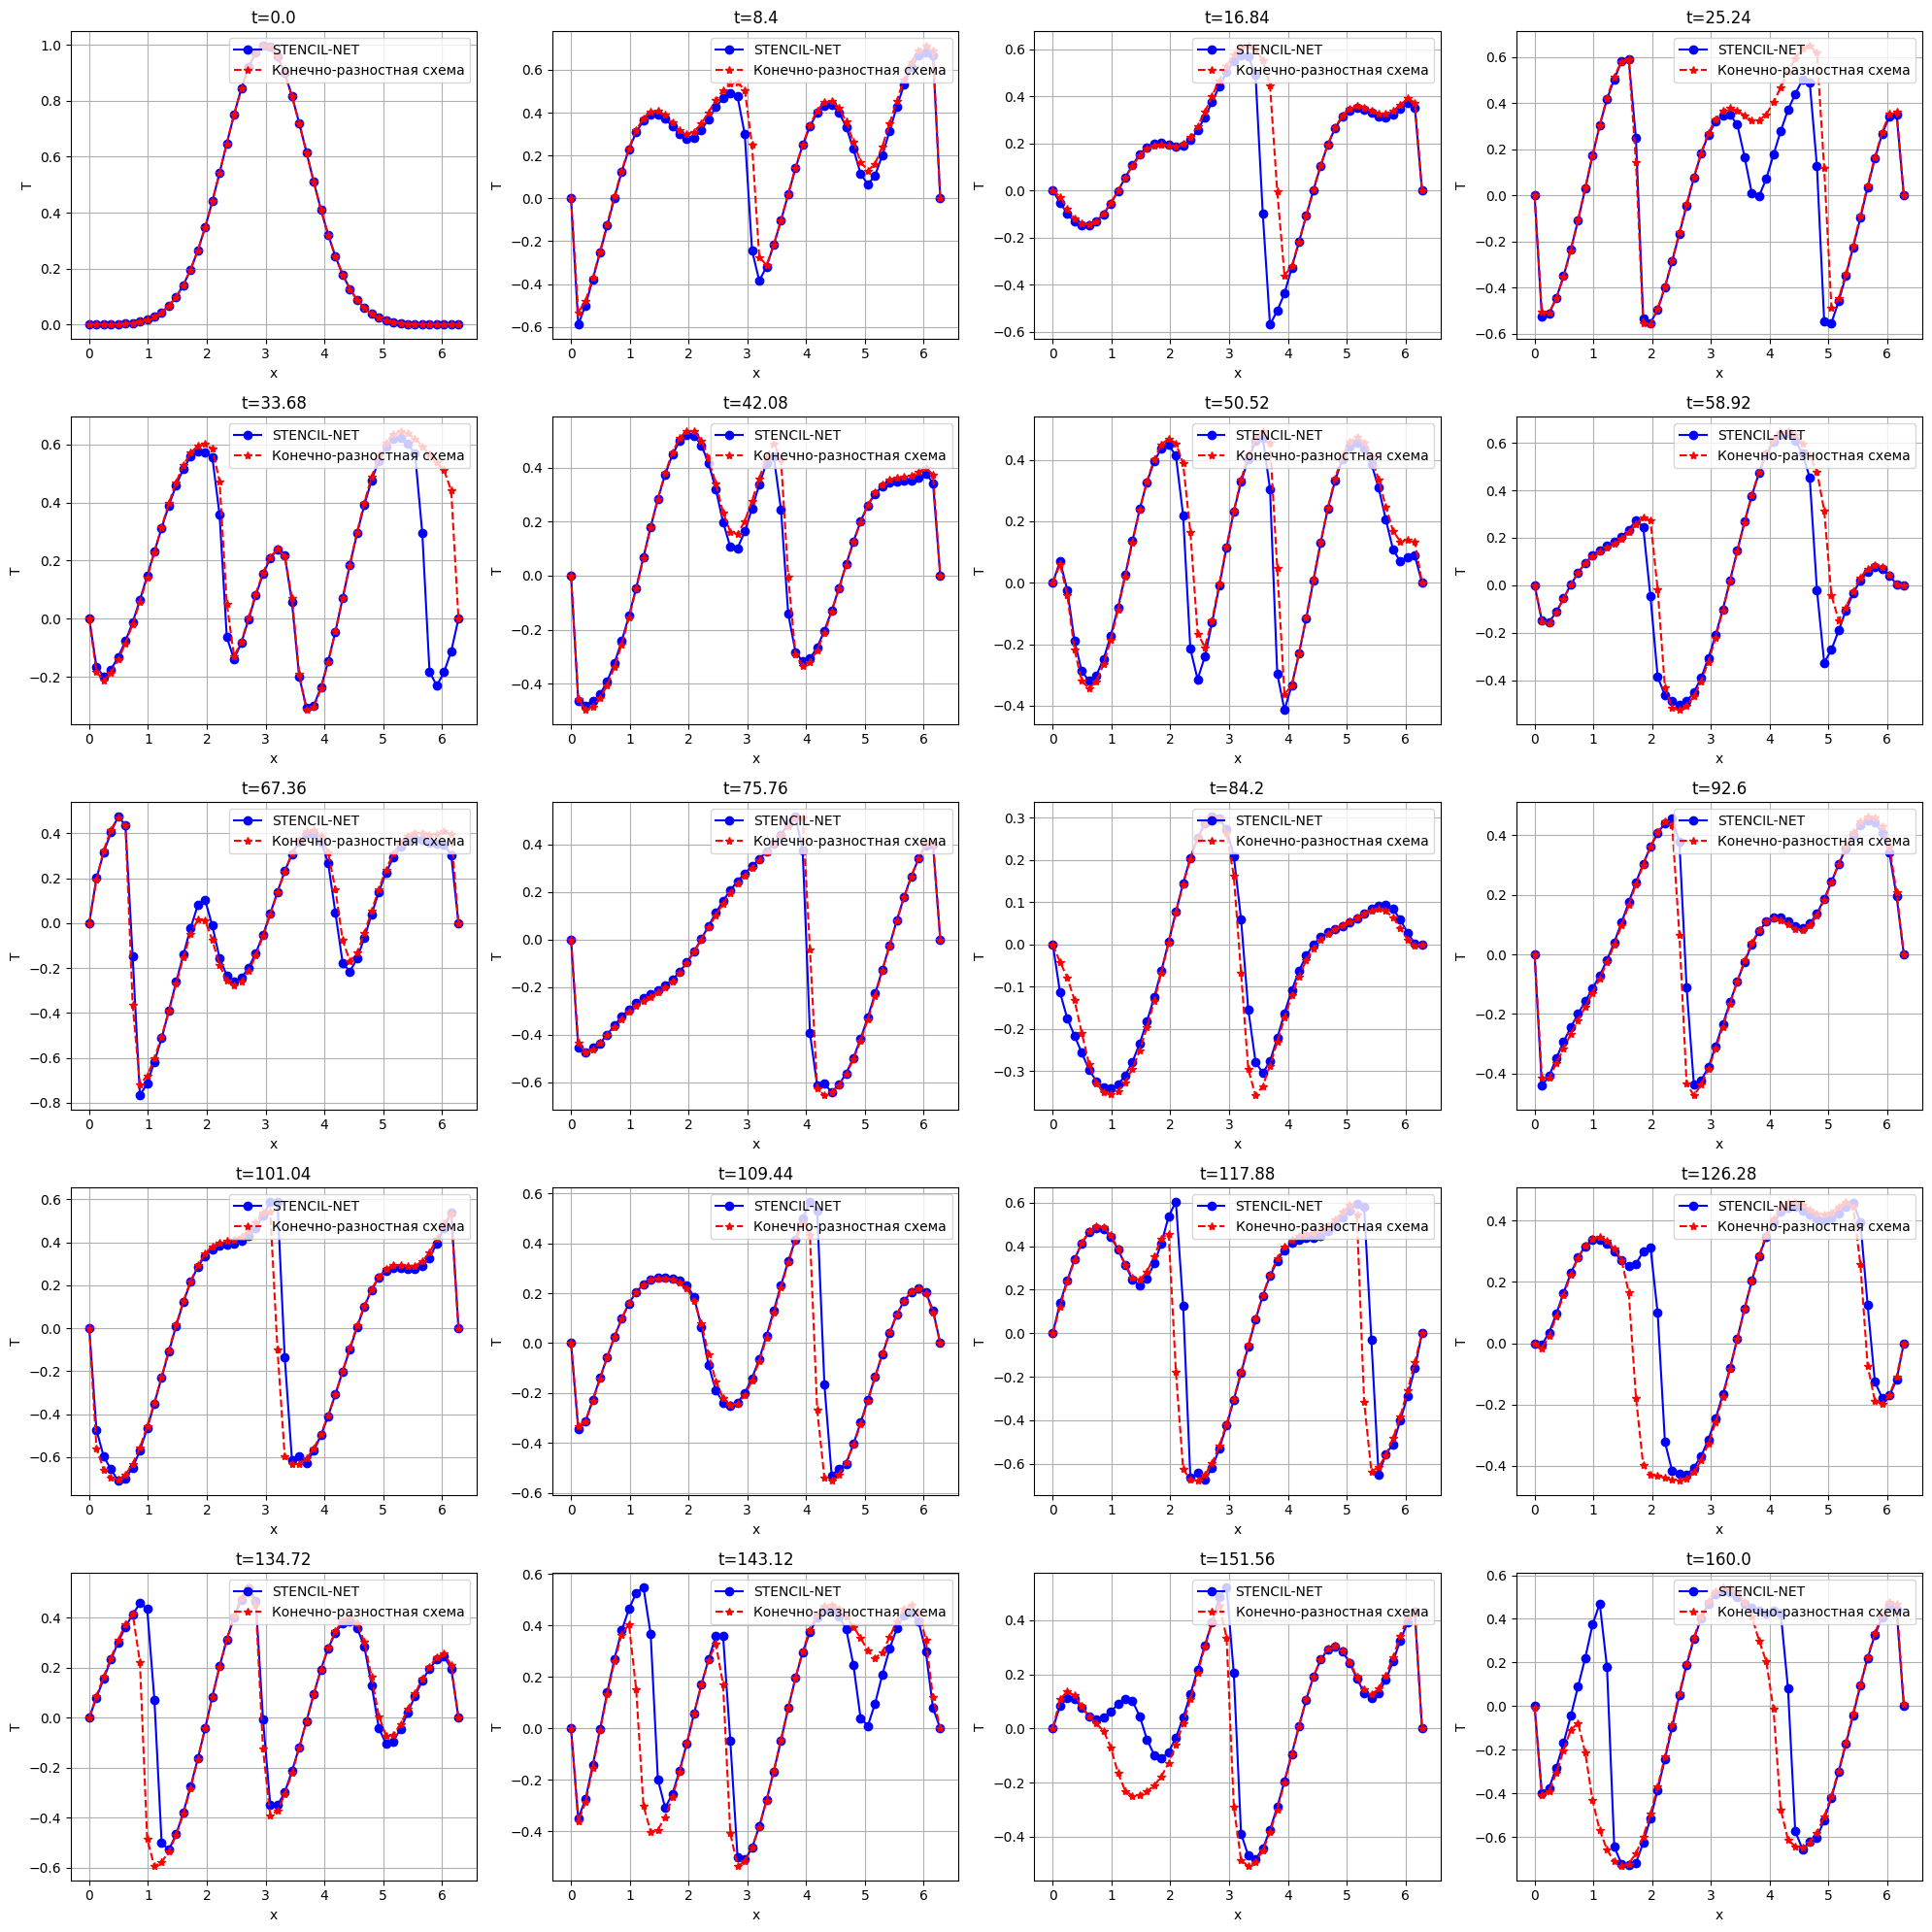



done


In [33]:

for i in range(len(epochs_lst)):
    
    print(fr'---------------Epochs = {epochs_lst[i]}-------------------')
    view_results(T_sim,x_sim,NN_sim_lst[i],v_coarse,T,dtc,n=101,fix_axes=False,
                epochs=epochs_lst[i],
                save_path = fr'{folder}/graphs/',
                save_name = fr'Result_epoch={epochs_lst[i]}',
                view_flag=False)
    view_result_metric(NN_sim_lst[i],v_coarse,T,dtc,L,dxc,
                       n_xticks=100,
                       save_path = fr'{folder}/graphs/',
                save_name = fr'Metric_epoch={epochs_lst[i]}')

    view_result_imshow(NN_sim_lst[i],v_coarse,T,dtc,L,dxc,
                       figsize=(10,4),aspect=27,n_xticks=101,n_yticks=5,
                       save_path = fr'{folder}/graphs/',
                       save_name = fr'Imshow_epoch={epochs_lst[i]}',
                       fix_colorbar_axes=False,
                       colorbar_min_max=[-0.1,1.1],cmap='seismic'
                       )
    
    make_gif(folder=fr'{folder}/graphs/',epochs=epochs_lst[i])

    # make_gif(folder=fr'{folder}/graphs/',epochs=epochs_lst[i],format='mp4')

    make_subplot_graphs(NN_sim_lst[0], v_coarse, x_sim, T_sim, T, dtc,20,nx=5,ny=4,
                        figsize=(20,20),
                        save_flg=True,
                        save_path = fr'{folder}/graphs/',
                       save_name = fr'SUBPLOT_{epochs_lst[i]}')

    print('\n')
print('done')

In [ ]:
assert 1==2,'stop point'

### cpu_vs_cuda

In [ ]:
model_cpu=pickle.load(open(fr'{folder}/models/net_epochs={epochs}_device=cpu', 'rb'))
model_cuda=pickle.load(open(fr'{folder}/models/net_epochs={epochs}_device=cuda', 'rb'))

In [ ]:
model_cpu.layer[0].weight.data.numpy()

In [ ]:
model_cuda.layer[0].weight.cpu().data.numpy()

### RK3_mae vs E1_mae

In [ ]:
rk3_mae=pd.read_csv(fr'RK3_mae.csv')
e1_mae=pd.read_csv(fr'E1_mae.csv')
plt.plot(rk3_mae['mae_list'],label='RK3')
plt.plot(e1_mae['mae_list'],label='E1')
plt.grid()
plt.legend()